The S414 is a slotted, natural-laminar-flow airfoil. It is designed to have a laminar bucket between CL=.1 and CL=.65, but also have the ability to achieve high angles of attack and lift coefficients[1]. Below, the windtunnel results and the CFD results from the literature are compared to the results predicted by viiflow.
For OVERFLOW, the transition model in [2] was used.

**Important:** The use of this airfoil is restricted [3]. The geometry of the geometry used here is *not* the geometry used in the other CFD analysis methods nor in the wind tunnel experiments. It has been digitzed and smoothed, with permission, from the reference.
As such, this is not a thorough comparison of CFD results and wind tunnel data, but merely an example of Multi-Element airfoil analysis. The good match should therefore be taken with a tbsp. of salt.

All CFD methods use a transition model, and all are able to predict the laminar bucket and show good agreement with the measurements. Viiflow does predict a stronger increase in drag below the laminar bucket compared to the other methods and the windtunnel results. All methods overpredict maximum lift, with viiflow and MSES closely agreeing on the lift slope, which is not surprising given their similar boundary layer formulation.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
interactive_plot = False

import numpy as np
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
if interactive_plot:
    %matplotlib notebook
    matplotlib.rcParams['figure.figsize'] = [10, 7] 
    lines = None
    fig, ax = plt.subplots(1,1)
else:
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = [12, 6]
%config InlineBackend.figure_format = 'svg'

AL: -7.000000 CL: -0.406329 CD0: 0.012072 CD1: 0.003067
AL: -6.800000 CL: -0.383380 CD0: 0.011745 CD1: 0.003079
AL: -6.600000 CL: -0.359945 CD0: 0.011315 CD1: 0.003089
AL: -6.400000 CL: -0.336165 CD0: 0.010896 CD1: 0.003103
AL: -6.200000 CL: -0.311734 CD0: 0.010543 CD1: 0.003117
AL: -6.000000 CL: -0.286881 CD0: 0.010243 CD1: 0.003130
AL: -5.800000 CL: -0.261526 CD0: 0.010000 CD1: 0.003142
AL: -5.600000 CL: -0.235806 CD0: 0.009791 CD1: 0.003154
AL: -5.400000 CL: -0.209250 CD0: 0.009434 CD1: 0.003168
AL: -5.200000 CL: -0.182843 CD0: 0.009242 CD1: 0.003180
AL: -5.000000 CL: -0.156435 CD0: 0.009091 CD1: 0.003191
AL: -4.800000 CL: -0.129399 CD0: 0.008820 CD1: 0.003203
AL: -4.600000 CL: -0.102485 CD0: 0.008624 CD1: 0.003213
AL: -4.400000 CL: -0.075623 CD0: 0.008452 CD1: 0.003221
AL: -4.200000 CL: -0.048846 CD0: 0.008262 CD1: 0.003228
AL: -4.000000 CL: -0.021426 CD0: 0.007883 CD1: 0.003236
AL: -3.400000 CL: 0.052712 CD0: 0.004009 CD1: 0.003122
AL: -3.200000 CL: 0.080063 CD0: 0.004010 CD1: 0.0

c:\users\maxra\scoop\apps\python\current\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\maxra\scoop\apps\python\current\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


AL: 5.000000 CL: 1.020874 CD0: 0.009730 CD1: 0.003666
AL: 5.500000 CL: 1.076163 CD0: 0.010276 CD1: 0.003664
AL: 6.000000 CL: 1.131461 CD0: 0.010793 CD1: 0.003663
AL: 6.500000 CL: 1.186788 CD0: 0.011338 CD1: 0.003660
AL: 7.000000 CL: 1.241505 CD0: 0.011918 CD1: 0.003651
AL: 7.500000 CL: 1.295955 CD0: 0.012552 CD1: 0.003641
AL: 8.000000 CL: 1.349303 CD0: 0.013430 CD1: 0.003618
AL: 8.500000 CL: 1.401708 CD0: 0.014405 CD1: 0.003593
AL: 9.000000 CL: 1.454065 CD0: 0.015400 CD1: 0.003566
AL: 9.500000 CL: 1.506008 CD0: 0.016338 CD1: 0.003543
AL: 10.000000 CL: 1.557570 CD0: 0.017355 CD1: 0.003515
AL: 10.500000 CL: 1.607951 CD0: 0.018457 CD1: 0.003485
AL: 11.000000 CL: 1.657586 CD0: 0.019658 CD1: 0.003456
AL: 11.500000 CL: 1.706072 CD0: 0.020979 CD1: 0.003423
AL: 12.000000 CL: 1.755266 CD0: 0.022059 CD1: 0.003403
AL: 12.500000 CL: 1.801116 CD0: 0.023546 CD1: 0.003362
AL: 13.000000 CL: 1.844470 CD0: 0.025329 CD1: 0.003318
AL: 13.500000 CL: 1.888839 CD0: 0.026786 CD1: 0.003282
AL: 14.000000 CL: 1.

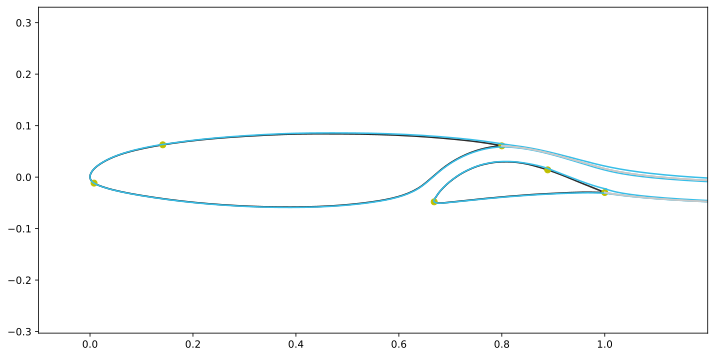

In [3]:

# Read and repanel airfoil data
BASE = vft.repanel(vft.read_selig("S414Main.dat")[:,::-1],290)
SLOT = vft.repanel(vft.read_selig("S414Aft.dat")[:,::-1],290)
# More refined in laminar bucket
AOARANGE = np.r_[np.arange(-7,5,0.2),np.arange(5,20.5,0.5)]
#AOARANGE = np.r_[np.arange(5,22,0.5)]

# Scale to c=1
SCALE = np.max(SLOT[0,:])
BASE = BASE/SCALE;
SLOT = SLOT/SCALE;

# Setup
RE = 1.0e6
ncrit = 9.0
Mach = 0.1
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=AOA0)
s.IterateWakes = False
s.Silent = True



# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

# result array
alv = []
clv = []
cdv = []

lines = None # For plot function
if not interactive_plot:
    fig, ax = plt.subplots(1,1)
else:
    # For interactive plot. We iterate for 10 iterations and, if not converged, can observe the solution.
    s.Itermax = 10
for alpha in AOARANGE:
    s.Alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.Itermax)): # Make effectively 100 iterations, but show some in between
        [x,flag,res,grad,_] = vf.iter(x,bl,p,s,res,grad)
        
        # Plot geometry and update interactively
        if interactive_plot:
            nres=np.sqrt(np.dot(res.T,res))
            lines = vfp.plot_geometry(ax,p,bl,lines)
            title = "AOA %f RES %f"%(alpha,nres)
            ax.set_title(title)
            fig.canvas.draw()
        # Just plot a single geometry at AOA = 5°
        elif alpha==5:
            lines = vfp.plot_geometry(ax,p,bl,lines)

        # Decide whether to stop iterating
        if flag>0:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD0: %f CD1: %f' % (alpha,clv[-1],bl[0].CD,bl[1].CD) ) 
            break


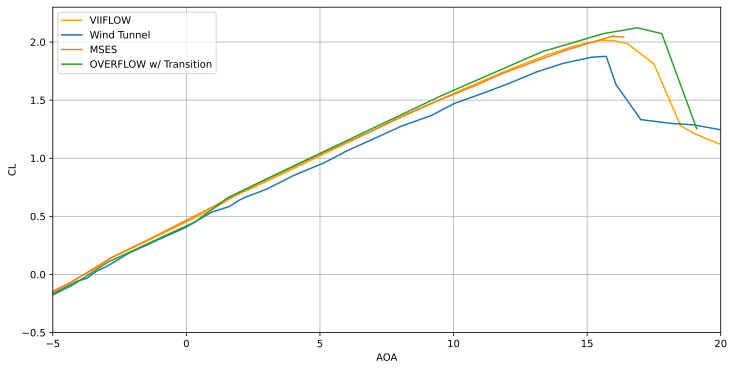

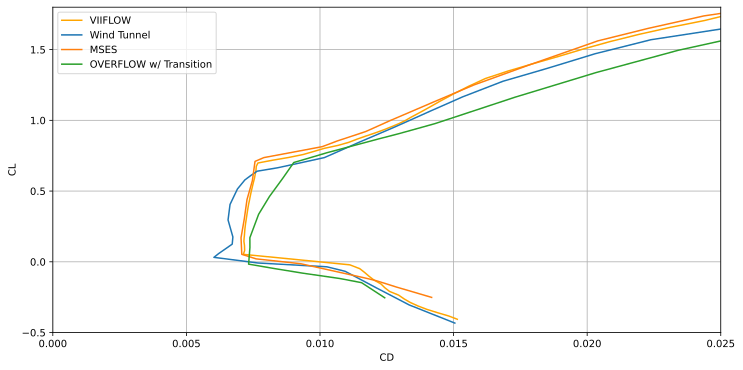

In [4]:
# Load airfoil measurement data
PolarMaughmerWT = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[0,1])
PolarMaughmerMSES = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[2,3])
PolarMaughmerOVERFLOW = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[4,5])
CLMaughmerWT = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[0,1])
CLMaughmerMSES = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[2,3])
CLMaughmerOVERFLOW = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[4,5])

# Make a new plot with the results
fig,ax = plt.subplots(1,1)
ax.plot(alv,clv,color="orange")
ax.plot(CLMaughmerWT.T[0],CLMaughmerWT.T[1])
ax.plot(CLMaughmerMSES.T[0],CLMaughmerMSES.T[1])
ax.plot(CLMaughmerOVERFLOW.T[0],CLMaughmerOVERFLOW.T[1])

ax.set_xlabel('AOA')
ax.set_ylabel('CL')
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.grid(1)
ax.set_xlim([-5,20])
ax.set_ylim([-0.5,2.3])

fig,ax = plt.subplots(1,1)
ax.plot(cdv,clv,color="orange")
ax.plot(PolarMaughmerWT.T[0]/1000,PolarMaughmerWT.T[1])
ax.plot(PolarMaughmerMSES.T[0]/1000,PolarMaughmerMSES.T[1])
ax.plot(PolarMaughmerOVERFLOW.T[0]/1000,PolarMaughmerOVERFLOW.T[1])

ax.set_xlabel('CD')
ax.set_ylabel('CL');
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.set_xlim([0,0.025])
ax.set_ylim([-0.5,1.8])
ax.grid(1)

[1] Mark D. Maughmer, James G. Coder, and Dan M. Somers, *Exploration of a Slotted, Natural-Laminar-Flow Airfoil Concept*, 2018 Applied Aerodynamics Conference. Atlanta, Georgia. 

[2] James G. Coder and Mark D. Maughmer, *Fluid Dynamics Compatible Transition Modeling Using an Amplification Factor Transport Equation*, AIAA Journal 2014 52:11, 2506-2512 

**[3] The original coordinates, and the concept of this airfoil, are patented under US Patent 6905092 B2.
To use this proprietary airfoil, a license agreement with *Airfoil, Incorporated* is necessary and its use is subject to distribution restrictions imposed by the U.S. Army.**